# Introduction to Modeling

## What are models?

https://en.wikipedia.org/wiki/Mathematical_model

A model is the use of mathematics as the language to describe a natural or man-made system. Models are used to understand systems and to help make predictions of the system behavior. Great models become Laws (like Newton's Laws or Einstein's Relativity). The key to modeling is to keep it simple, but not too simple.

It is tradition that models are organized as follows:

* Governing equations
* Supplementary sub-models
    * Defining equations
    * Constitutive equations
* Assumptions and constraints
    * Initial and boundary conditions
    * Classical constraints and kinematic equations

There are multiple classifications of Mathematical Models.
https://en.wikipedia.org/wiki/Mathematical_model#Classifications



In the simplest of terms a mathmatical model is just using independent variables (time, location, depth, etc.) to determine dependent variables (location, pressure, volume, etc.).

$$\begin{array}{c}
Dependent\\variable
\end{array} = f\left(\begin{array}{c}
independent\\variable
\end{array}, parameters, \begin{array}{c}
forcing\\functions
\end{array}\right )$$

Dependent variables are characteristic of the system. Independent variables are usually dimensions or time. Parameters are some form of the systems properties. Forcing functions are external influences to the system.


## An example modeling problem

### Newton's 2nd Law of Motion
The force acting on the body $F$ in *Newtons (N)* is equal to the mass $m$ of the body in *kg* times its acceleration $a$ in $m/s^2$

$${F=ma}$$

If we rearrange with get a more desciptive form:

$$a = \frac{F}{m}$$

where $a$ is the dependent variable, $m$ is the parameter reflecting a property of the system, and $F$ is obviously the forcing function.

The model has the following characteristics:
1. It describes a natural process
2. Its an idealization or simplifications (it doesn't include quantum or relativistic corrections)
3. It renders useful and reproducable results that can be used to predict behavior of a system

It is algebraic, so it is super easy to solve. The real fun is when we bring back the Calculus and solve the problem of a *Tom Petty Object* (a free falling body). 

![falling body](fig1.png)

Using the differential form of acceleration (the infinitesimal change of velocity with the change in time)  we can rewrite the 2nd Law as:

$$\frac{dv}{dt}=\frac{F}{m}$$

The next step is a force balance, the force down $F_D$ has to equal the force up $F_U$. The downward force is that of gravity:

$$F_D=mg$$

where g is gravitational constant $9.81m/s^2$ on Earth and assuming down is the "positive" direction. The upward force is slightly more complex and is known as *Drag Force*. For the time being, we will need to create a secondary (constituent) model for drag. We will assume it is linearly proportional to velocity and acts in the upward "negative" direction.

$$F_U=-cv$$

$c$ is the proportionality constant called the *drag coefficient* and is in $kg/s$.

Therefore doing our force balance, we come up with the following equation:

$$\frac{dv}{dt}=\frac{F}{m}=\frac{mg-cv}{m}$$

This can be simplified into the following differential equation:

$$\frac{dv}{dt}=g-\frac{c}{m}v$$

## Solving the Equation
### Symbolic Solutions in Python (Sympy)

#### Call the Sympy library
This line also initiates the "pretty" printing functionality of sympy

In [22]:
import sympy as sym
sym.init_printing()

#### Setup the variables and Build the Function

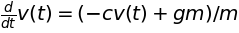

In [23]:
t, m, c, g = sym.symbols('t m c g')
v = sym.Function('v')(t)
dvdt = v.diff(t)
expr = sym.Eq(dvdt, ((m*g)-(c*v))/m)
expr

#### Determine what kind of ODE it is (wish this existed when I took DiffEQ)

In [24]:
sym.classify_ode(expr)

('separable',
 '1st_linear',
 'Bernoulli',
 'almost_linear',
 '1st_power_series',
 'lie_group',
 'nth_linear_constant_coeff_undetermined_coefficients',
 'nth_linear_constant_coeff_variation_of_parameters',
 'separable_Integral',
 '1st_linear_Integral',
 'Bernoulli_Integral',
 'almost_linear_Integral',
 'nth_linear_constant_coeff_variation_of_parameters_Integral')

#### Solve for the general expression

In [25]:
soln = sym.dsolve(expr,v)
soln

#### Find the exact solution for initial conditions ($v=0$ at $t = 0$)


In [26]:
ics = [soln.lhs.subs(t,0) - 0,soln.rhs.subs(t,0) - 0]
ics

In [27]:
constant = sym.solve(ics) 
constant

#### Substitute Coefficient to Find Exact Solution

In [28]:
C1 = sym.symbols('C1')

In [29]:
ext_soln = soln.subs(constant[0])
ext_soln

#### Make it pretty with simplify

In [187]:
sym.simplify(ext_soln)

#### Evaluating for specific values (Substitution)
If the falling object is on Earth ($9.81m/s$), has a mass of $68kg$, and has a drag coefficient of $12.5kg/s$. 

In [31]:
ext_soln_const = ext_soln.subs([(g, 9.81),(m, 68.),(c, 12.5)])

In [32]:
sym.simplify(ext_soln_const)

#### Plotting 

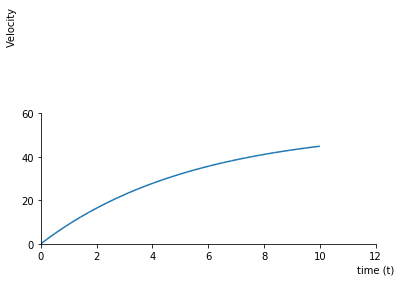

In [190]:
p1 = sym.plot(ext_soln_const.rhs,xlim = {0,12}, ylim = {0,100},xlabel = 'time (t)',ylabel = 'Velocity',show=False)
p1.show()

In [191]:
times = [0,2,4,6,8,10,12,sym.oo] #sym.oo is infinity
for time in times:
    print(sym.simplify(ext_soln_const.subs(t,time)))

Eq(v(0), 3.5527136788005e-14)
Eq(v(2), 16.4175591688156)
Eq(v(4), 27.7844450851434)
Eq(v(6), 35.6544392850263)
Eq(v(8), 41.1033202856899)
Eq(v(10), 44.8759157165525)
Eq(v(12), 47.4879155534424)
Eq(v(oo), 53.3664)


### Numerical Solution

We can approximate the Second law derivative using what is known as a *finite difference*, meaning we can compute the slope on ever more refined finite intervals. So an approximation of the derivative is as follows:

$$\frac{dv}{dt}\cong\frac{\Delta v}{\Delta t}=\frac{v(t_{i+1})-v(t_i)}{t_{i+1}-t_i}$$

where $\Delta v$ and $\Delta t$ are the differences in velocity and time computed over finite intervals. This is visualized below.

![finite difference](fig2.png)

Remember your calculus. 

$$\frac{dv}{dt}=\lim_{t \to 0} \frac{\Delta v}{\Delta t}$$

So to best approximate the solution, we would continue to shrink the difference, here called the time step ($\Delta t$) to improve our results. Lets substitute and test it out.

$$\frac{v(t_{i+1})-v(t_i)}{t_{i+1}-t_i}=g-\frac{c}{m}v(t_i)$$

If we rearrange this we get the following:

$$v(t_{i+1})=v(t_i)+\left [g-\frac{c}{m}v(t_i)\right](t_{i+1}-t_i)$$

Now we have an algebraic equation that we can use to solve numerically for the solution. Using the following algorithm:

$$New\space Value = old\space value+slope \times step\space size$$

This is called Euler's Method and we will come back to it later in this course.

Now lets create a function that will call the algebraic equation defined above for the differential. 

In [1]:
def diff(vti,g,c,m,ti,delta_t):
    ti_1 = ti + delta_t
    vti_1 = vti + (g - (c/m)*vti)*(ti_1-ti)
    return vti_1

#### Testing the algebraic solution for values of $g=9.81m/s^2$, $c=12.5kg/s$, and $m=68.0$. Using a time step of 2 seconds

In [86]:
g = 9.81
c = 12.5
m = 68.
delta_t = 2.
diff(0,g,c,m,0,delta_t)

#### Creating a loop to calculate at different time steps (0sec, 2sec, 4sec etc) and print the values

In [19]:
velocity = [0,0,0,0,0,0,0,0]
delta_t = 0
while True:
    velocity[(int(delta_t/2))+1]=diff(velocity[(int(delta_t/2))],9.81,12.5,68.,delta_t,2)
    print ('velocity', 'at time', delta_t,'=', velocity[int(delta_t/2)])
    delta_t = delta_t + 2
    if delta_t == 14:
        break

velocity at time 0 = 0
velocity at time 2 = 19.62
velocity at time 4 = 32.02676470588236
velocity at time 6 = 39.87221885813149
velocity at time 8 = 44.833314866171385
velocity at time 10 = 47.97047851831426
velocity at time 12 = 49.95427318069872


#### Comparison of the numerical solution with the results of the analytical solution and calculating the error

In [56]:
import numpy as np
delta_t = 0
velocity_a = [0,0,0,0,0,0,0,0]
times = [0,2,4,6,8,10,12,sym.oo] #sym.oo is infinity
for time in times:
    velocity_a[(int(delta_t/2))]=sym.simplify(ext_soln_const.subs(t,time)).rhs
    delta_t += 2
abs_error = np.absolute(np.subtract(velocity, velocity_a))
rel_error = np.divide(abs_error,np.absolute(velocity_a))*100

#### Plotting

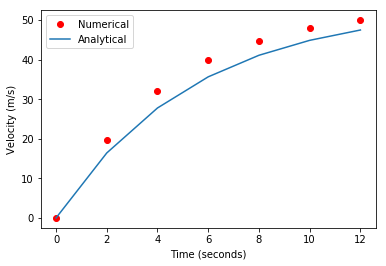

In [45]:
import matplotlib.pyplot as plt
p2 = plt.plot(times[0:7],velocity[0:7], 'ro', label = 'Numerical') 
p3 = plt.plot(times[0:7],velocity_a[0:7], label ='Analytical')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.legend()

#### Create a table in Pandas with all the values

In [57]:
import pandas as pd
df = pd.DataFrame({'Numerical Velocity': np.around((np.asarray(velocity)).astype(np.double),2), 'Analytical Velocity': np.around((np.asarray(velocity_a)).astype(np.double),2), 
                   'Absolute Error':np.around(abs_error.astype(np.double),2), 'Relative Error':np.around(rel_error.astype(np.double),2)})
df

,Numerical Velocity,Analytical Velocity,Absolute Error,Relative Error
0,0.00,0.00,0.00,100.00
1,19.62,16.42,3.20,19.51
2,32.03,27.78,4.24,15.27
3,39.87,35.65,4.22,11.83
4,44.83,41.10,3.73,9.07
5,47.97,44.88,3.09,6.90
6,49.95,47.49,2.47,5.19
7,51.21,53.37,2.16,4.04


### Approximation and Error
It can be seen that for the time step of 2 seconds, the numerical model underestimates the analytical value by upwards of 20% that becomes lower as the time increases. However, we can use more computational time to make a more accurate estimate.

In [87]:
def solver(delta_v,ti,vi,vels,tims):
    t_1 = ti+delta_v
    while ti<= 12.0:
        
        v_1 = vi+(g-(c/m)*vi)*(t_1-ti)
        vi = v_1
        ti = t_1
        vels = np.append(vels,v_1)
        tims = np.append(tims,t_1)
        t_1 = ti+delta_v
        
    return vels,tims

In [111]:
vi = 0.
ti = 0.
vels = np.zeros(1)
tims = np.zeros(1)
vels = np.append(vels,vi)
tims = np.append(tims,ti)
delta_val = 1. #this is the time step value

In [109]:
%time vels,tims = solver(delta_val,ti,vi,vels,tims)

Wall time: 997 µs


In [90]:
df = pd.DataFrame({'Velocity':vels,'Time':tims})
df = df.round(4)

In [93]:
VV = df.loc[df['Time'] == 2]['Velocity']

In [94]:
((VV)-sym.simplify(ext_soln_const.subs(t,2.0)).rhs)/sym.simplify(ext_soln_const.subs(t,2.0)).rhs*100

3    8.52222195027662
Name: Velocity, dtype: object

Text(0, 0.5, 'Error')

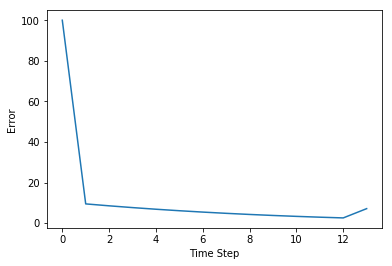

In [108]:
dt = [1.]
an_new = np.zeros(len(vels))
i = 0
for time in tims:
    an_new[i] = sym.simplify(ext_soln_const.subs(t,time)).rhs
    i += 1
an_new[len(an_new)-1] = sym.simplify(ext_soln_const.subs(t,1000)).rhs
abs_error1 = np.absolute(np.subtract(vels, an_new))
err= np.divide(abs_error1,np.absolute(an_new))*100
t_cpu = [4.05E-6]
df2 = pd.DataFrame({'Time_Step':tims,'Error':err})

plt.plot(df2.Time_Step,df2.Error,)
plt.xlabel('Time Step')
plt.ylabel('Error')

Text(0, 0.5, 'CPU Time')

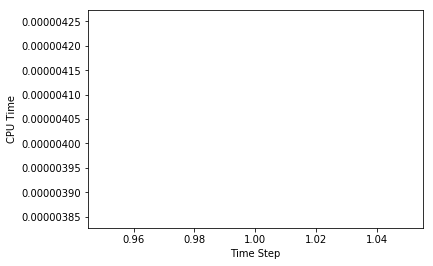

In [96]:
plt.plot(df2.Time_Step,df2.CPU_Time)
plt.xlabel('Time Step')
plt.ylabel('CPU Time')